In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchinfo import summary
import torchvision.transforms as T
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from datetime import datetime
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
log_path = './log/'+datetime.now().strftime('%Y-%m-%d_%H-%M-%S')+'/'
os.mkdir(log_path)
seed = 20510099
rng = torch.Generator().manual_seed(seed)
parallel_cuda = [1,2,3,0]
model_cuda = 1
bs = 256

### Data overview

Normal samples:
Shape: torch.Size([4, 103, 96])
Sample point:  tensor([0.3373, 0.3373, 0.3373, 1.0000])


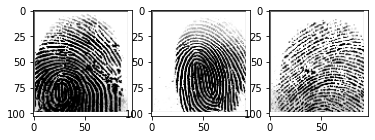

Altered samples(Easy):
Shape: torch.Size([1, 103, 96])
Sample point:  tensor([0.3373])


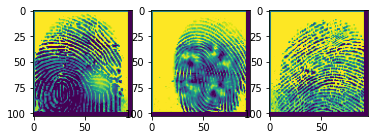

Altered samples(Medium):
Shape: torch.Size([1, 103, 96])
Sample point:  tensor([0.0353])


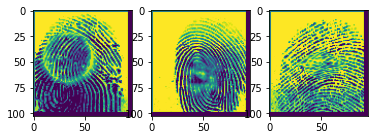

Altered samples(Hard):
Shape: torch.Size([1, 103, 96])
Sample point:  tensor([0.3294])


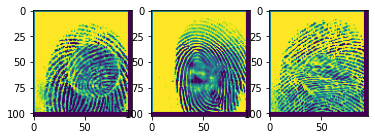

In [3]:
totensor = T.Compose([T.ToTensor()])

def show_image_info(paths):
    if len(paths) == 0: return

    imgs = []
    for i in range(len(paths)):
        imgs.append(Image.open(paths[i]))

    print('Shape:', totensor(imgs[0]).shape)
    print('Sample point: ', totensor(imgs[0])[:, 50, 46])
    fig, ax = plt.subplots(1, len(imgs))
    for i in range(len(imgs)):
        ax[i].imshow(imgs[i])
    plt.show()
#####################################################################
print('Normal samples:')
paths = ['./data/Real/1__M_Right_index_finger.BMP',
            './data/Real/72__M_Right_little_finger.BMP',
            './data/Real/281__M_Left_thumb_finger.BMP']
show_image_info(paths)
#####################################################################
print('Altered samples(Easy):')
paths = ['./data/Altered/Easy/1__M_Right_index_finger_CR.BMP',
            './data/Altered/Easy/72__M_Right_little_finger_Obl.BMP',
            './data/Altered/Easy/281__M_Left_thumb_finger_Zcut.BMP']
show_image_info(paths)
#####################################################################
print('Altered samples(Medium):')
paths = ['./data/Altered/Medium/1__M_Right_index_finger_CR.BMP',
            './data/Altered/Medium/72__M_Right_little_finger_Obl.BMP',
            './data/Altered/Medium/281__M_Left_thumb_finger_Zcut.BMP']
show_image_info(paths)
#####################################################################
print('Altered samples(Hard):')
paths = ['./data/Altered/Hard/109__F_Right_index_finger_CR.BMP',
            './data/Altered/Hard/72__M_Right_little_finger_Obl.BMP',
            './data/Altered/Hard/281__M_Left_thumb_finger_Zcut.BMP']
show_image_info(paths)

### Dataset and Dataloader

In [4]:
def extract_imgpath_id(path):
    if path[-1] != '/':
        path = path + '/'

    X = []
    y = []
    filenames = os.listdir(path)
    for filename in filenames:
        if filename[-3:] == 'BMP':
            X.append(path+filename)
            y.append(int(filename.split('__')[0])-1)
    return X, y

X, y = extract_imgpath_id('./data/Real')
print(X[231], y[231])
print(X[1293], y[1293])
print(X[4927], y[4927])

./data/Real/121__F_Left_little_finger.BMP 120
./data/Real/217__M_Left_ring_finger.BMP 216
./data/Real/544__M_Right_middle_finger.BMP 543


In [5]:
class Fingerprints_Dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.X, self.y = extract_imgpath_id(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = Image.open(self.X[idx])
        if self.transform:
            img = self.transform(img)
        img = torch.unsqueeze(img[0, :, :], 0) # obtain only grayscale value (1xHxW)
        label = self.y[idx]
        return img, label

In [6]:
resize_totensor = T.Compose([
    T.Resize(96, max_size=103),
    T.CenterCrop((100,90)),
    T.ToTensor()])

normal_set = Fingerprints_Dataset('./data/Real', resize_totensor)
easy_set = Fingerprints_Dataset('./data/Altered/Easy', resize_totensor)
medium_set = Fingerprints_Dataset('./data/Altered/Medium', resize_totensor)
hard_set = Fingerprints_Dataset('./data/Altered/Hard', resize_totensor)

valid_normal_size = 4000
valid_altered_size = 3000
valid_easy_size = int(0.6*valid_altered_size)
valid_medium_size = int(0.24*valid_altered_size)
valid_hard_size = int(0.16*valid_altered_size)

test_normal_size = 2000
test_altered_size = 1000
test_easy_size = int(0.6*test_altered_size)
test_medium_size = int(0.24*test_altered_size)
test_hard_size = int(0.16*test_altered_size)

train_easy_size = len(easy_set)-valid_easy_size-test_easy_size
train_medium_size = len(medium_set)-valid_medium_size-test_medium_size
train_hard_size = len(hard_set)-valid_hard_size-test_hard_size

valid_normal_set, test_normal_set = random_split(normal_set, [valid_normal_size, test_normal_size], rng)
train_easy_set, valid_easy_set, test_easy_set = random_split(easy_set, [train_easy_size, valid_easy_size, test_easy_size], rng)
train_medium_set, valid_medium_set, test_medium_set = random_split(medium_set, [train_medium_size, valid_medium_size, test_medium_size], rng)
train_hard_set, valid_hard_set, test_hard_set = random_split(hard_set, [train_hard_size, valid_hard_size, test_hard_size], rng)

train_set = ConcatDataset([train_easy_set, train_medium_set, train_hard_set])
valid_set = ConcatDataset([valid_normal_set, valid_easy_set, valid_medium_set, valid_hard_set])
test_set = ConcatDataset([test_normal_set, test_easy_set, test_medium_set, test_hard_set])

print('Train set size: %4d (Easy: %4d, Medium: %4d, Hard: %4d)'
        % (len(train_set), len(train_easy_set), len(train_medium_set), len(train_hard_set)))
print('Valid set size: %4d (Normal: %4d, Easy: %4d, Medium: %4d, Hard: %4d)'
        % (len(valid_set), len(valid_normal_set), len(valid_easy_set), len(valid_medium_set), len(valid_hard_set)))
print('Test set size: %4d (Normal: %4d, Easy: %4d, Medium: %4d, Hard: %4d)'
        % (len(test_set), len(test_normal_set), len(test_easy_set), len(test_medium_set), len(test_hard_set)))

del normal_set, easy_set, medium_set, hard_set

Train set size: 45270 (Easy: 15531, Medium: 16107, Hard: 13632)
Valid set size: 7000 (Normal: 4000, Easy: 1800, Medium:  720, Hard:  480)
Test set size: 3000 (Normal: 2000, Easy:  600, Medium:  240, Hard:  160)


In [7]:
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, generator=rng, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=bs, shuffle=True, generator=rng, num_workers=4)

### Model

In [8]:
class Base_Block(nn.Module):
    def __init__(self, Cin, Cout):
        super(Base_Block, self).__init__()
        self.conv2d = nn.Conv2d(Cin, Cout, 2)
        self.bn = nn.BatchNorm2d(Cout)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, X):
        result = self.relu(self.bn(self.conv2d(X)))
        result = self.maxpool(result)
        return result

class Fingerprints_Model(nn.Module):
    def __init__(self):
        super(Fingerprints_Model, self).__init__()

        self.base_block1 = Base_Block(1, 32)
        self.base_block2 = Base_Block(32, 32)
        self.base_block3 = Base_Block(32, 64)
        self.base_block4 = Base_Block(64, 64)
        self.base_block5 = Base_Block(64, 128)

        self.fc1 = nn.Sequential(
            nn.Linear(128*2*1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Linear(512, 600)

    def forward(self, X):
        result = self.base_block1(X)
        result = self.base_block2(result)
        result = self.base_block3(result)
        result = self.base_block4(result)
        result = self.base_block5(result)

        result = result.view(-1, 128*2*1)
        result = self.fc1(result)
        result = self.fc2(result)

        return result

In [9]:
temp_model = Fingerprints_Model()
print(summary(temp_model, (bs, 1, 100, 90), device=f"cuda:{model_cuda}"))
del temp_model

Layer (type:depth-idx)                   Output Shape              Param #
Fingerprints_Model                       --                        --
├─Base_Block: 1-1                        [256, 32, 49, 44]         --
│    └─Conv2d: 2-1                       [256, 32, 99, 89]         160
│    └─BatchNorm2d: 2-2                  [256, 32, 99, 89]         64
│    └─ReLU: 2-3                         [256, 32, 99, 89]         --
│    └─MaxPool2d: 2-4                    [256, 32, 49, 44]         --
├─Base_Block: 1-2                        [256, 32, 24, 21]         --
│    └─Conv2d: 2-5                       [256, 32, 48, 43]         4,128
│    └─BatchNorm2d: 2-6                  [256, 32, 48, 43]         64
│    └─ReLU: 2-7                         [256, 32, 48, 43]         --
│    └─MaxPool2d: 2-8                    [256, 32, 24, 21]         --
├─Base_Block: 1-3                        [256, 64, 11, 10]         --
│    └─Conv2d: 2-9                       [256, 64, 23, 20]         8,256
│    └─B

In [9]:
# class TransLearning_Fingerprints_Model(nn.Module):
#     def __init__(self):
#         super(TransLearning_Fingerprints_Model, self).__init__()
#         self.resnet = models.resnet18(True)
#         self.fc = nn.Linear(1000, 600)
    
#     def forward(self, X):
#         result = self.resnet(X)
#         result = self.fc(result)
#         return result

# temp_model = TransLearning_Fingerprints_Model()
# print(summary(temp_model, (1, 1, 103, 96)))
# del temp_model

### Training

In [10]:
def save_data(path, filename, data):
    if not os.path.exists(path+filename):
        file = open(path+filename, 'a')
        file.write('data\n')
    else:
        file = open(path+filename, 'a')

    for item in data:
        file.write(str(item)+'\n')
    file.close()

def train_phase(model, train_loader, criterion, optimizer):
    model.train()
    itr_loss = []
    epoch_loss = 0.0
    epoch_corrects = 0

    for inputs, labels in train_loader:
        # forward pass
        inputs, labels = inputs.cuda(model_cuda), labels.cuda(model_cuda)
        net = nn.DataParallel(model, device_ids=parallel_cuda)
        outputs = net(inputs)

        # count corrects
        preds = torch.argmax(outputs.data, dim=1)
        epoch_corrects += torch.sum(preds == labels.data)

        # calculate loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        itr_loss.append(loss.item())
        
        # backword pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate epoch loss and acc
    epoch_loss = epoch_loss / len(train_loader)
    epoch_acc = epoch_corrects / float(len(train_loader.dataset))
    return epoch_loss, epoch_acc.item(), itr_loss

def valid_phase(model, valid_loader, criterion):
    with torch.no_grad():
        model.eval()
        itr_loss = []
        epoch_loss = 0.0
        epoch_corrects = 0

        for inputs, labels in valid_loader:
            # forward pass
            inputs, labels = inputs.cuda(model_cuda), labels.cuda(model_cuda)
            net = nn.DataParallel(model, device_ids=parallel_cuda)
            outputs = net(inputs)
            
            # count corrects
            preds = torch.argmax(outputs.data, dim=1)
            epoch_corrects += torch.sum(preds == labels.data)

            # calculate loss
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            itr_loss.append(loss.item())

        # calculate epoch loss and acc
        epoch_loss = epoch_loss / len(valid_loader)
        epoch_acc = epoch_corrects / float(len(valid_loader.dataset))
            
        return epoch_loss, epoch_acc.item(), itr_loss
        
def train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer):
    itr = [0, 0]
    best_loss = 10000.0
    for epoch in range(num_epochs):
        train_loss, train_acc, train_itr_loss = train_phase(model, train_loader, criterion, optimizer)
        valid_loss, valid_acc, valid_itr_loss = valid_phase(model, valid_loader, criterion)

        # save loss and acc
        save_data(log_path, 'train_epoch_loss.csv', [train_loss])
        save_data(log_path, 'train_epoch_acc.csv', [train_acc])
        save_data(log_path, 'train_itr_loss.csv', train_itr_loss)
        save_data(log_path, 'valid_epoch_loss.csv', [valid_loss])
        save_data(log_path, 'valid_epoch_acc.csv', [valid_acc])
        save_data(log_path, 'valid_itr_loss.csv', valid_itr_loss)

        # save best model
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), log_path+'best_model_params.pth')

        # write data to tensorboard
        for loss in train_itr_loss:
            writer.add_scalar("training loss vs iteration", loss, itr[0])
            itr[0] += 1
        for loss in valid_itr_loss:
            writer.add_scalar("validation loss vs iteration", loss, itr[1])
            itr[1] += 1
        writer.add_scalar("training loss vs epoch", train_loss, epoch)
        writer.add_scalar("validation loss vs epoch", valid_loss, epoch)
        
        # display result per 10 epoch
        if (epoch+1)%1 == 0:
            print('Epoch[{:2d}/{:2d}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
                  .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))
    print("Finished Training")

In [11]:
model = Fingerprints_Model().cuda(model_cuda)
num_epochs = 150
criterion = nn.CrossEntropyLoss().cuda(model_cuda)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

writer = SummaryWriter(log_path)

tic = time.time()
train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer)
toc = time.time()
save_data(log_path, 'start_end_time.csv', [tic, toc, toc-tic])
print('Total training time: {}s'.format(toc-tic))

Epoch[ 1/150], Train Loss: 6.3630, Train Acc: 0.0047, Valid Loss: 6.0075,  Valid Acc: 0.0249
Epoch[ 2/150], Train Loss: 5.9719, Train Acc: 0.0176, Valid Loss: 5.6475,  Valid Acc: 0.0669
Epoch[ 3/150], Train Loss: 5.6403, Train Acc: 0.0388, Valid Loss: 5.3048,  Valid Acc: 0.1029
Epoch[ 4/150], Train Loss: 5.3568, Train Acc: 0.0614, Valid Loss: 5.0256,  Valid Acc: 0.1430
Epoch[ 5/150], Train Loss: 5.0945, Train Acc: 0.0907, Valid Loss: 4.7511,  Valid Acc: 0.1903
Epoch[ 6/150], Train Loss: 4.8493, Train Acc: 0.1218, Valid Loss: 4.4957,  Valid Acc: 0.2427
Epoch[ 7/150], Train Loss: 4.6053, Train Acc: 0.1614, Valid Loss: 4.2485,  Valid Acc: 0.2907
Epoch[ 8/150], Train Loss: 4.3700, Train Acc: 0.1976, Valid Loss: 3.9851,  Valid Acc: 0.3240
Epoch[ 9/150], Train Loss: 4.1359, Train Acc: 0.2379, Valid Loss: 3.7426,  Valid Acc: 0.3959
Epoch[10/150], Train Loss: 3.9093, Train Acc: 0.2818, Valid Loss: 3.5130,  Valid Acc: 0.4434
Epoch[11/150], Train Loss: 3.6892, Train Acc: 0.3194, Valid Loss: 3.28

### Evaluation and test

In [12]:
def plot_loss_acc(train_result, valid_result, xlabel, ylabel, title):
    plt.plot(range(len(train_result)), train_result, 'r-', range(len(valid_result)), valid_result, 'b-')
    plt.legend(('Train', 'Valid'))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def display_test_result(X, y, pred):
    toimg = T.Compose([T.ToPILImage()])
    fig, ax = plt.subplots(4, len(y)//4)
    fig.set_figwidth(25)
    fig.set_figheight(21)
    counter = 0

    for j in range(4):
        for i in range(len(y)//4):
            title = "GT: {}; Pred:{}".format(y[counter], pred[counter])
            ax[j, i].set_title(title)
            ax[j, i].imshow(toimg(X[counter]))
            counter += 1
    plt.show()

# log_path = './log/2021-11-30_10-56-19/'
train_loss = pd.read_csv(log_path+'train_epoch_loss.csv')
train_itr_loss = pd.read_csv(log_path+'train_itr_loss.csv')
train_acc = pd.read_csv(log_path+'train_epoch_acc.csv')
valid_loss = pd.read_csv(log_path+'valid_epoch_loss.csv')
valid_itr_loss = pd.read_csv(log_path+'valid_itr_loss.csv')
valid_acc = pd.read_csv(log_path+'valid_epoch_acc.csv')

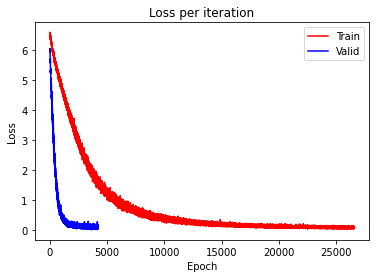

In [19]:
plot_loss_acc(train_itr_loss, valid_itr_loss, 'Epoch', 'Loss', 'Loss per iteration')

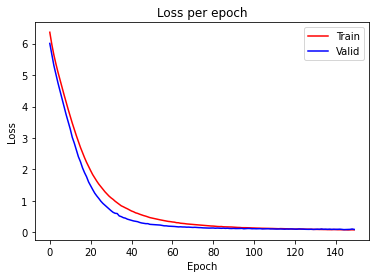

In [20]:
plot_loss_acc(train_loss, valid_loss, 'Epoch', 'Loss', 'Loss per epoch')

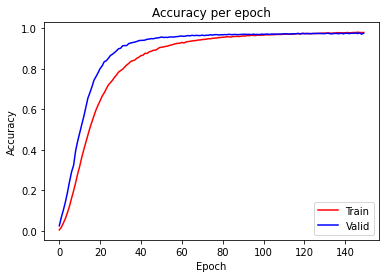

In [21]:
plot_loss_acc(train_acc, valid_acc, 'Epoch', 'Accuracy', 'Accuracy per epoch')

In [16]:
test_loader = DataLoader(test_set, len(test_set))
X_test, y_test = next(iter(test_loader))

In [17]:
model = Fingerprints_Model().cuda(model_cuda)
with torch.no_grad():
    model.eval()
    model.load_state_dict(torch.load(log_path+'best_model_params.pth'))
    y_pred = torch.argmax(model(X_test.cuda(model_cuda)).data, dim=1)
    save_data(log_path, 'test_y_test.csv', y_test.tolist())
    save_data(log_path, 'test_y_pred.csv', y_pred.tolist())

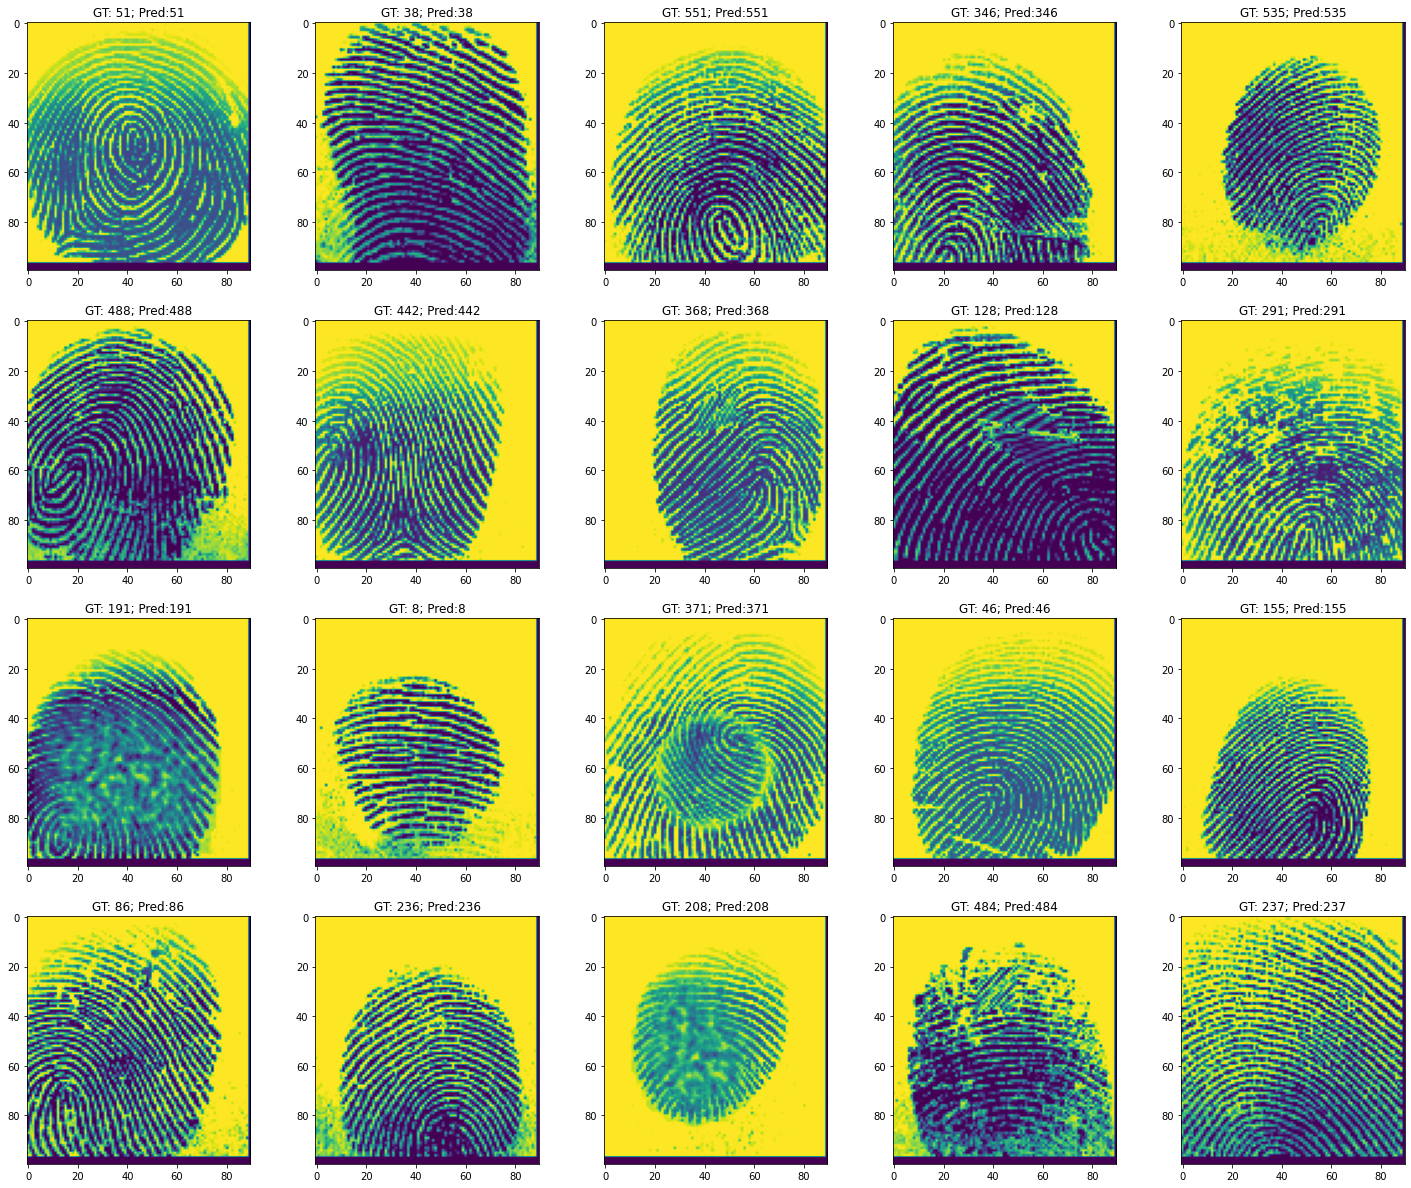

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         6
           9       0.78      1.00      0.88         7
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         4
          13       1.00      0.83      0.91         6
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         6
          17       1.00    

In [18]:
samples_index = torch.randperm(len(y_test), generator=rng)[:20]
display_test_result(X_test[samples_index], y_test[samples_index], y_pred.cpu()[samples_index])
print(classification_report(y_test, y_pred.cpu(), labels=torch.unique(y_test, sorted=True), zero_division=0))